In [22]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime


from tensorflow.python.client import device_lib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL



In [23]:
#(train_ds_global, test_ds_global), ds_info = tfds.load("cifar10" , split =["train", "test"] , as_supervised=True , with_info=True)
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
#shuffle_files=True

#tfds.show_examples(train_ds_global, ds_info)

In [24]:
class BasicConv(tf.keras.Model):
    def __init__(self, dropout_rate=0, batch_norm=False):
        super(BasicConv, self).__init__()

        self.batch_norm = batch_norm

        self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05)
        self.metrics_list = [[tf.keras.metrics.CategoricalAccuracy(name="test_accuracy"),
                             tf.keras.metrics.Mean(name="test_loss"),
                             tf.keras.metrics.Mean(name="test_frob_norm")],
                             [tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
                             tf.keras.metrics.Mean(name="train_loss"),
                             tf.keras.metrics.Mean(name="train_frob_norm")]]

        self.optimizer = tf.keras.optimizers.Adam()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.2, l2=0.15))
        self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.2, l2=0.15))
        self.pooling = tf.keras.layers.MaxPooling2D()
        self.dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.2, l2=0.15))
        self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.2, l2=0.15))
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)

        self.batch_normalization = tf.keras.layers.BatchNormalization()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x, training=False):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.dropout_layer1(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.dropout_layer2(x)
        x = self.batch_normalization(x, training)
        x = self.out(x)
        return x

    @tf.function
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm

    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model



    # 4. reset all metrics objects
    def reset_metrics(self, num):
        for metric in self.metrics[num]:
            metric.reset_states()



    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update metrics
        self.metrics_list[1][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[1][1].update_state(loss)
        self.metrics_list[1][2].update_state(self.compute_frobenius())
        
        # return a dict with metric information
        return {m.name : m.result() for m in self.metrics_list[1]}



    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # update metrics
        self.metrics_list[0][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[0][1].update_state(loss)
        self.metrics_list[0][2].update_state(self.compute_frobenius())

        # return a dict with metric information 
        return {m.name : m.result() for m in self.metrics_list[0]}

In [25]:

def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [26]:
def prepare_cifar10_data(cifar10, batch_size, augmentation=None):
    #convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all

    if augmentation:
      cifar10 = cifar10.repeat(3)
      cifar10 = cifar10.map(lambda img, label : (augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

    cifar10 = cifar10.cache()
    cifar10 = cifar10.shuffle(4096)
    cifar10 = cifar10.batch(batch_size)
    cifar10 = cifar10.prefetch(tf.data.AUTOTUNE)

    return cifar10

# trains the model by iterating through the dataset and applying training_step method epochs time
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, memory):

    metrics = []

    # iterate over epochs
    for epoch in range(epochs):
        tf.print(f"epoch: {epoch}")

        # train steps on all batches in the training data
        for (img, label) in train_ds:
            metrics = model.train_step((img, label))
            
            # keep data in summary with metrics
            with train_summary_writer.as_default():
                for metric in model.metrics_list[1]:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        for (key, value) in metrics.items():
            memory[key].append(value.numpy())

        memory = test_loop(model=model,
                           test_ds=test_ds,
                           val_summary_writer=val_summary_writer,
                           memory=memory)
        
        # print current metric values and reset the metrics
        tf.print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])
        model.reset_metrics(1)

    return memory


# tests overall performance of model
def test_loop(model, test_ds, val_summary_writer, memory):
    # test steps on every item in test dataset
    for (img, label) in test_ds:
        metrics = model.test_step((img, label))
        
        # keep data with metrics
        with val_summary_writer.as_default():
            for metric in model.metrics_list[0]:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    for (key, value) in metrics.items():
        memory[key].append(value.numpy())

    print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])

    model.reset_metrics(0)

    return memory

# with augmentation
# augmentation is used in the data pipeline in order to remesh the training and testdata
# this is used to let the network get trained on different training data which is supposed to pretend overfitting
# The pretending should happen, because its hardder for the network to just remember the training data and apply it on validation data

# makes train and test worse somehow, leads to huge ups and down in the accuracy, depending on what the validation data is at the timestep


basic_model = BasicConv(dropout_rate=0.01)

augment = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1)
])

train_dataset = train_ds.apply(lambda ds: prepare_cifar10_data(ds, 32, augment))
val_dataset = val_ds.apply(lambda ds: prepare_cifar10_data(ds, 32))
tfds.benchmark(train_dataset, batch_size=32)

print("\n************ Training ************\n")

memory = {"test_accuracy" : [],
          "test_loss" : [],
          "test_frob_norm" : [],
          "train_accuracy" : [],
          "train_loss" : [],
          "train_frob_norm" : []
          }

memory = training_loop(basic_model,
                       train_ds=train_dataset,
                       test_ds=val_dataset,
                       epochs=tf.constant(10),
                       train_summary_writer=train_summary_writer,
                       memory=memory)

# visualize accuracy, loss and frobenius norm
def visualization(accuracies, losses, frobenius, name):
    plt.figure()
    line1, = plt.plot(accuracies, "b")
    line2, = plt.plot(losses, "r" )

    frob_new = frobenius/np.max(frobenius) * np.max(losses)
    line3, = plt.plot(frob_new, "y" )

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3),("Accuracy", "Loss", "Frobenius Norm"))
    plt.savefig(name)
    plt.show()

  0%|          | 1/4688 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1798.63 ex/sec (total: 150016 ex, 83.41 sec)
Examples/sec (First only) 10.14 ex/sec (total: 32 ex, 3.16 sec)
Examples/sec (First excluded) 1868.94 ex/sec (total: 149984 ex, 80.25 sec)

************ Training ************

epoch: 0
['test_accuracy : 0.42172524333000183', 'test_loss : 1.5089149475097656', 'test_frob_norm : 56.39558029174805']
['train_accuracy : 0.361774742603302',
 'train_loss : 1.521411657333374',
 'train_frob_norm : 46.73494338989258']
epoch: 1
['test_accuracy : 0.6134185194969177', 'test_loss : 1.2628605365753174', 'test_frob_norm : 69.18025207519531']
['train_accuracy : 0.5110921263694763',
 'train_loss : 1.2652297019958496',
 'train_frob_norm : 63.28004455566406']
epoch: 2
['test_accuracy : 0.5814696550369263', 'test_loss : 1.2467092275619507', 'test_frob_norm : 78.39848327636719']
['train_accuracy : 0.5439419746398926',
 'train_loss : 1.1793521642684937',
 'train_frob_norm : 74.00199127197266']
epoch:

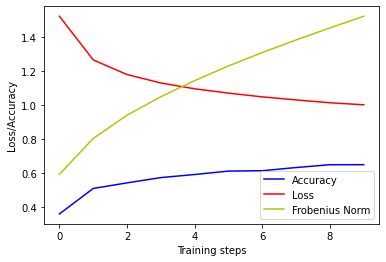

In [27]:
# as we can see the frobenius norm is increasing, the validation loss is increasing at the end which indicates overfitting
visualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")
print()

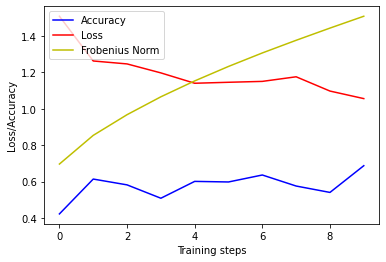

In [28]:
# as we can see the frobenius norm is increasing, the validation loss is increasing at the end which indicates overfitting
visualization(memory["test_accuracy"], memory["test_loss"], memory["test_frob_norm"], "aug_test")